<a href="https://colab.research.google.com/github/giakomorssi/Deloitte_Project/blob/main/02_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from sklearn.metrics import mean_squared_error

import pandas as pd

# Change Colab runtime to GPU
import os
os.environ['COLAB_TPU_ADDR'] = ''
os.environ['COLAB_GPU_ALLOC'] = '1'
os.environ['COLAB_GPU'] = '1'
print("Runtime switched to GPU")

import tensorflow as tf

if not tf.test.gpu_device_name():
    print('GPU device not found')
else:
    print('GPU device found:', tf.test.gpu_device_name())

# This code sets the runtime to use the GPU if available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

pd.set_option('display.max_columns', None)

!pip install -q category_encoders

Mounted at /content/drive
Runtime switched to GPU
GPU device found: /device:GPU:0
Default GPU Device: /device:GPU:0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 3.9 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/University/Deloitte/SupplyChainDataset.csv', encoding = 'latin-1')

# Old System

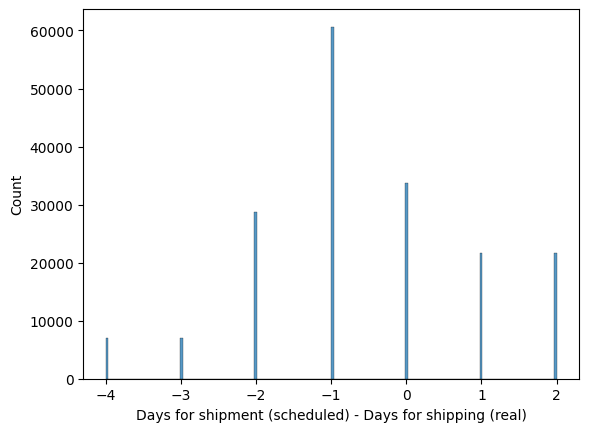

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

df['expect_real'] = df['Days for shipment (scheduled)'] - df['Days for shipping (real)']

sns.histplot(df['expect_real'])
plt.xlabel('Days for shipment (scheduled) - Days for shipping (real)')
plt.ylabel('Count')
plt.show()

# Cleaning the Data

In [ ]:
# Remove Na and Empty Columns

df.drop(['Product Description', 'Order Zipcode', 'Order Profit Per Order', 'Customer Email', 'Customer Password', 'Customer Country', 'Customer Id', 'Customer Fname', 'Customer Lname', 'Customer Street', 'Order Country', 'Product Card Id', 'Product Category Id', 'Product Image', 'Customer State', 'shipping date (DateOrders)', 'order date (DateOrders)'], axis = 1, inplace = True) 
df.dropna(inplace = True) #remove 1 missing value

## Encoding

### Label Encoding

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(['Days for shipping (real)', 'Product Name'], axis = 1)
y = df['Days for shipping (real)']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
import pandas as pd
from category_encoders import LeaveOneOutEncoder

# initialize the encoder
enc = LeaveOneOutEncoder(cols=['Customer City', 'Order City', 'Order State', 'Order Region'])

# fit and transform the entire dataset
X_train = enc.fit_transform(X_train, y_train)
X_test = enc.transform(X_test)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Select columns for one-hot encoding
one_hot_cols = [0, 7, 9, 12, 15, 30]
# Type, Department Name, Category Name, Market, Order Status, Customer Segment

# Fit one-hot encoder to training data
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")

# Apply one-hot encoder to training and test data
X_train_one_hot = one_hot_encoder.fit_transform(X_train.iloc[:, one_hot_cols])
X_test_one_hot = one_hot_encoder.transform(X_test.iloc[:, one_hot_cols])

# Remove original columns from training and test data
X_train = X_train.drop(X_train.columns[one_hot_cols], axis=1)
X_test = X_test.drop(X_test.columns[one_hot_cols], axis=1)

# Concatenate one-hot encoded columns with remaining data
X_train = pd.concat([pd.DataFrame(X_train_one_hot.toarray()), X_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([pd.DataFrame(X_test_one_hot.toarray()), X_test.reset_index(drop=True)], axis=1)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Shipping Mode
custom_order = ['Same Day', 'First Class', 'Second Class', 'Standard Class']
le.fit(custom_order)
X_train['Shipping Mode'] = le.fit_transform(X_train['Shipping Mode'])
X_test['Shipping Mode'] = le.transform(X_test['Shipping Mode'])

# Delivery Status
# Define the custom order
custom_order = ['Shipping on time', 'Advance shipping', 'Late delivery', 'Shipping canceled']
le.fit(custom_order)
X_train['Delivery Status'] = le.fit_transform(X_train['Delivery Status'])
X_test['Delivery Status'] = le.transform(X_test['Delivery Status'])

## Scale the Data

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train.iloc[:, 82:] = scaler.fit_transform(X_train.iloc[:, 82:])
X_test.iloc[:, 82:] = scaler.transform(X_test.iloc[:, 82:])

<ipython-input-9-6700864cfc85>:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_train.iloc[:, 82:] = scaler.fit_transform(X_train.iloc[:, 82:])
<ipython-input-9-6700864cfc85>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_test.iloc[:, 82:] = scaler.transform(X_test.iloc[:, 82:])


In [ ]:
import pandas as pd
import numpy as np
import pickle

# Split the dataset into features and target
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_train = np.ravel(y_train)

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Prediction

## Choosing the Model

Epoch 1/100
2257/2257 - 14s - loss: 1.0233 - mean_squared_error: 0.4961 - val_loss: 0.5201 - val_mean_squared_error: 0.4008 - 14s/epoch - 6ms/step
Epoch 2/100
2257/2257 - 10s - loss: 0.4768 - mean_squared_error: 0.3879 - val_loss: 0.4497 - val_mean_squared_error: 0.3778 - 10s/epoch - 4ms/step
Epoch 3/100
2257/2257 - 10s - loss: 0.4485 - mean_squared_error: 0.3840 - val_loss: 0.4237 - val_mean_squared_error: 0.3644 - 10s/epoch - 4ms/step
Epoch 4/100
2257/2257 - 9s - loss: 0.4359 - mean_squared_error: 0.3792 - val_loss: 0.4345 - val_mean_squared_error: 0.3804 - 9s/epoch - 4ms/step
Epoch 5/100
2257/2257 - 10s - loss: 0.4307 - mean_squared_error: 0.3774 - val_loss: 0.4279 - val_mean_squared_error: 0.3762 - 10s/epoch - 4ms/step
Epoch 6/100
2257/2257 - 10s - loss: 0.4252 - mean_squared_error: 0.3738 - val_loss: 0.4408 - val_mean_squared_error: 0.3905 - 10s/epoch - 4ms/step
Epoch 7/100
2257/2257 - 13s - loss: 0.4222 - mean_squared_error: 0.3722 - val_loss: 0.4134 - val_mean_squared_error: 0.3

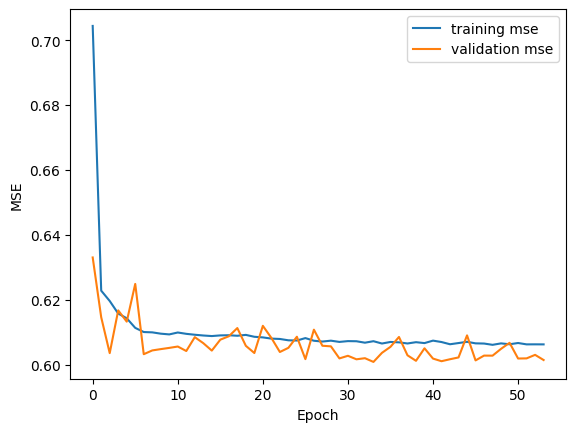

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define the neural network architecture
model = Sequential()
model.add(Dense(516, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.005))) 
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(1, activation='linear'))

# Compile the model with mean squared error loss function and Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Define the early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_mean_squared_error', patience=20, verbose=2, mode='min')
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/University/Deloitte/models_lr/nn12 .h5', monitor='val_mean_squared_error', save_best_only=True, mode='min')

# Fit the model to the training data with early stopping and model checkpoint callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=2, callbacks=[early_stopping, model_checkpoint])

# Evaluate the model on the test data
loss, mse = model.evaluate(X_test, y_test, verbose=0)
print('Mean Squared Error on test set: {:.4f}'.format(mse))

# Plot the training and validation loss over epochs
import matplotlib.pyplot as plt
plt.plot(np.sqrt(history.history['mean_squared_error']), label='training mse')
plt.plot(np.sqrt(history.history['val_mean_squared_error']), label='validation mse')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
import numpy as np

model = load_model('/content/drive/MyDrive/University/Deloitte/models_lr/nn1.h5')

loss, mse = model.evaluate(X_test, y_test, verbose=0)

print(f'rMSE :{np.sqrt(mse)}, MSE: {mse}, Loss: {loss}')

rMSE :0.600909857508441, MSE: 0.3610926568508148, Loss: 0.39926594495773315
